In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.all import load_learner
from torchvision import transforms


In [ ]:
OUTPUT_FOLDER = "."

# Pfade definieren
DATASET_DIR = "../balanced_dataset_split/balanced_dataset_split"  # Relativer Pfad
JSON_PATH = "../train_test_split_new.json"  # Relativer Pfad
BASE_PATH = "../basemodel_outputs"  # Relativer Pfad

# Fine-tuned Model Pfade
fine_model_paths = [
    f"{BASE_PATH}/basemodel_ViT_bs64+augm+iNat.pkl",
    f"{BASE_PATH}/googlenet_bs128+aug.pkl",
    f"{BASE_PATH}/resnet50_bs16+aug+iNat.pkl"
]
fine_model_names = [os.path.basename(p) for p in fine_model_paths]

# Base Model Pfade
base_model_paths = [
    f"{BASE_PATH}/basemodel_ViT_bs64.pkl",
    f"{BASE_PATH}/basemodel_googlenet_bs128.pkl",
    f"{BASE_PATH}/basemodel_resnet50_bs16.pkl"
]
base_model_names = [os.path.basename(p) for p in base_model_paths]

# Mapping für schöne Namen
pretty_names = {
    "basemodel_ViT_bs64.pkl": "ViT Basemodel",
    "basemodel_googlenet_bs128.pkl": "GoogLeNet Basemodel",
    "basemodel_resnet50_bs16.pkl": "ResNet50 Basemodel",
    "basemodel_ViT_bs64+augm+iNat.pkl": "ViT",
    "googlenet_bs128+aug.pkl": "GoogLeNet",
    "resnet50_bs16+aug+iNat.pkl": "ResNet50"
}

for model in fine_model_paths:
    print(model)

for model in base_model_paths:
    print(model)

../basemodel_outputs/basemodel_ViT_bs64+augm+iNat.pkl
../basemodel_outputs/googlenet_bs128+aug.pkl
../basemodel_outputs/resnet50_bs16+aug+iNat.pkl
../basemodel_outputs/basemodel_ViT_bs64.pkl
../basemodel_outputs/basemodel_googlenet_bs128.pkl
../basemodel_outputs/basemodel_resnet50_bs16.pkl


In [ ]:
# Testdaten laden
with open(JSON_PATH, "r") as f:
    split_data = json.load(f)

df_test = pd.DataFrame(split_data["test"])
df_test["image_path"] = df_test["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Label-zu-ID Mapping
all_labels = sorted(df_test["label"].unique())
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Modelle laden
fine_models = [load_learner(path) for path in fine_model_paths]
base_models = [load_learner(path) for path in base_model_paths]

df_test.head()

,file_path,label,image_path
0,test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG,acinonyx jubatus,../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG
1,test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG,acinonyx jubatus,../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG
2,test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG,acinonyx jubatus,../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG
3,test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG,acinonyx jubatus,../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG
4,test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG,acinonyx jubatus,../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG


In [ ]:
# Evaluation Funktion
def evaluate_model(learner, df, model_name, label2id):
    true_labels = []
    pred_labels = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    for idx, row in df.iterrows():
        img = Image.open(row["image_path"]).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        output = learner.model(input_tensor)
        pred = output.argmax(1).item()

        true_label = label2id[row["label"]]
        true_labels.append(true_label)
        pred_labels.append(pred)

    report = classification_report(true_labels, pred_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    cm = confusion_matrix(true_labels, pred_labels)

    return report_df, cm

# Modelle evaluieren
reports = {}
conf_matrices = {}

for learner, model_name in zip(fine_models, fine_model_names):
    print(f"Evaluating model {model_name}")
    report_df, cm = evaluate_model(learner, df_test, model_name, label2id)
    reports[model_name] = report_df
    conf_matrices[model_name] = cm

base_reports = {}
base_conf_matrices = {}

for learner, model_name in zip(base_models, base_model_names):
    print(f"Evaluating model {model_name}")
    report_df, cm = evaluate_model(learner, df_test, model_name, label2id)
    base_reports[model_name] = report_df
    base_conf_matrices[model_name] = cm

print("All models evaluated.")

Evaluating model basemodel_ViT_bs64+augm+iNat.pkl
Evaluating model googlenet_bs128+aug.pkl
Evaluating model resnet50_bs16+aug+iNat.pkl
Evaluating model basemodel_ViT_bs64.pkl
Evaluating model basemodel_googlenet_bs128.pkl
Evaluating model basemodel_resnet50_bs16.pkl
✅ All models evaluated.


/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavo/.conda/envs/Katha/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Fine-tuned F1-Scores saved.


,ViT,GoogLeNet,ResNet50
numididae,1.000000,0.857143,1.000000
corvus albus,0.975000,0.955414,0.912500
pteroclidae,0.959596,0.922330,0.948980
papio anubis,0.970874,0.920000,0.921569
eupodotis rueppellii,1.000000,0.875000,0.933333
cn-francolins,1.000000,0.903226,0.896552
procavia capensis,1.000000,0.937500,0.857143
torgos tracheliotos,0.970000,0.880000,0.908163
loxodanta africana,0.964467,0.891089,0.872928
neotis ludwigii,0.960784,0.871795,0.893204


✅ Heatmap for Fine-tuned models saved as PDF.


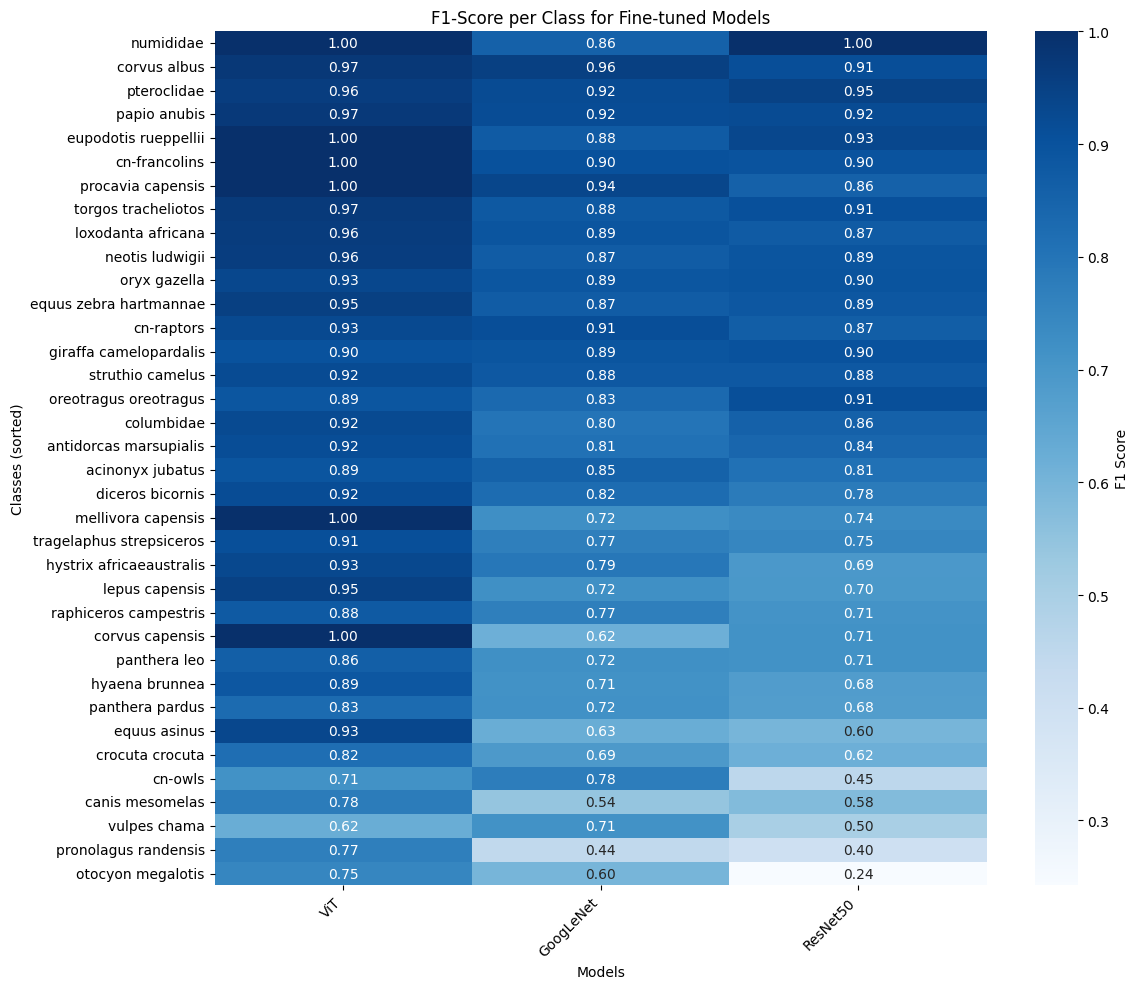

In [ ]:
# Fine-tuned F1-Scores extrahieren
fine_f1_tables = []

for model_name in fine_model_names:
    report_df = reports[model_name]
    class_only = report_df.iloc[:-3]
    f1 = class_only["f1-score"]
    f1.name = pretty_names[model_name]
    fine_f1_tables.append(f1)

fine_f1_df = pd.concat(fine_f1_tables, axis=1)
fine_f1_df.index = [id2label[int(idx)] for idx in fine_f1_df.index]

# Durchschnittlichen F1-Score berechnen und sortieren
fine_f1_df["Average_F1"] = fine_f1_df.mean(axis=1)
fine_f1_df = fine_f1_df.sort_values("Average_F1", ascending=False)
fine_f1_df = fine_f1_df.drop(columns=["Average_F1"])  # Optional: wieder löschen

# Tabelle speichern
fine_f1_df.to_csv(os.path.join(OUTPUT_FOLDER, "fine_tuned_models_f1_scores.csv"), index=True)
print("Fine-tuned F1-Scores saved.")

display(fine_f1_df)

# Heatmap Fine-tuned Modelle
plt.figure(figsize=(12, 10))
sns.heatmap(fine_f1_df, annot=True, cmap="Blues", fmt=".2f", cbar_kws={'label': 'F1 Score'})
plt.title('F1-Score per Class for Fine-tuned Models')
plt.xlabel('Models')
plt.ylabel('Classes (sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.savefig(os.path.join(OUTPUT_FOLDER, "fine_tuned_models_f1_heatmap.pdf"), dpi=300)

print("Heatmap for Fine-tuned models saved as PDF.")

plt.show()


✅ Classwise F1-Score differences saved.
✅ Heatmap for classwise F1-score differences saved.


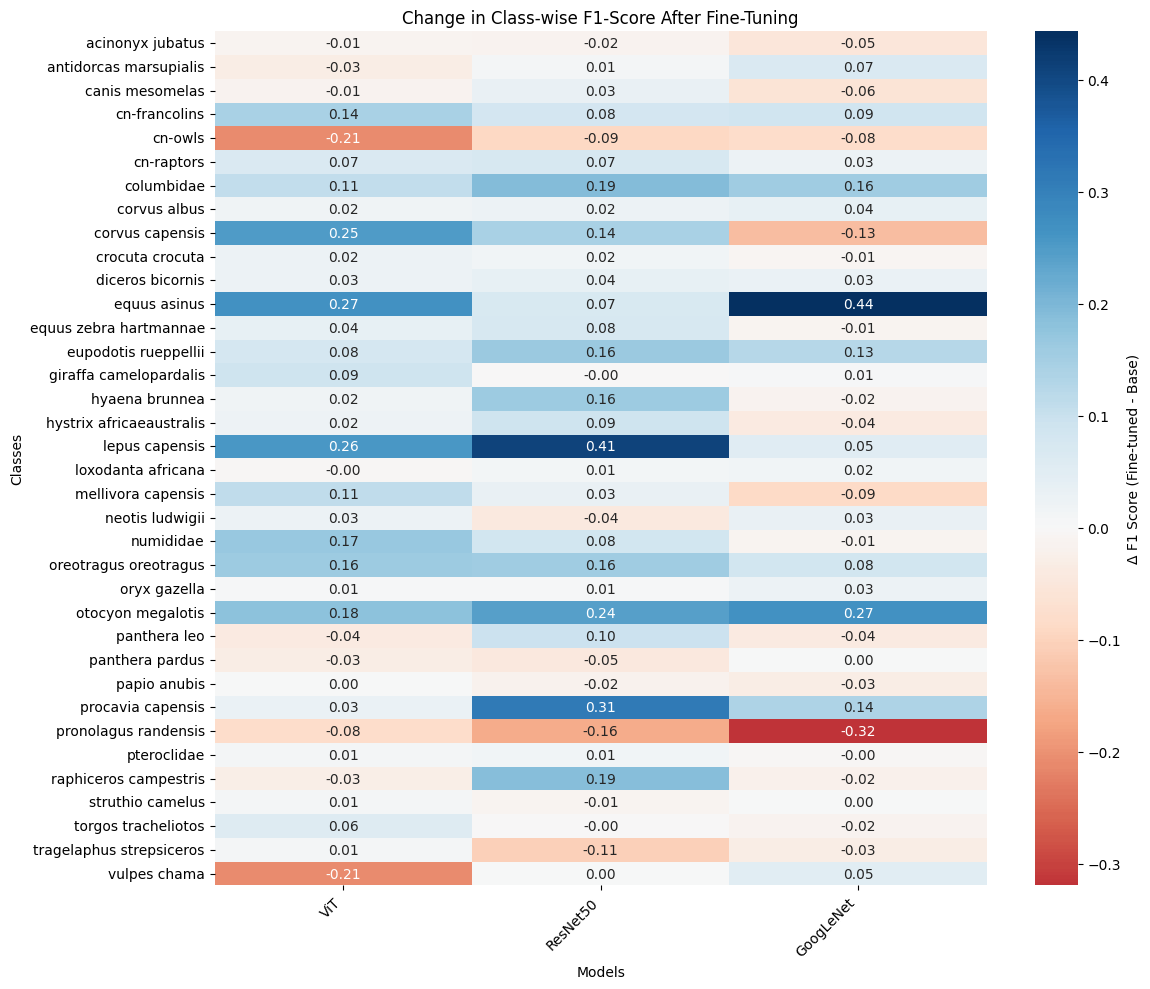

In [ ]:
# Difference Fine-tuned vs Basemodels 
# Heatmap

# Base F1-Scores extrahieren
base_f1_tables = []

for model_name in base_model_names:
    report_df = base_reports[model_name]
    class_only = report_df.iloc[:-3]
    f1 = class_only["f1-score"]
    f1.name = pretty_names[model_name]
    base_f1_tables.append(f1)

base_f1_df = pd.concat(base_f1_tables, axis=1)
base_f1_df.index = [id2label[int(idx)] for idx in base_f1_df.index]

# Differenz berechnen
diff_f1_df = pd.DataFrame()

for base_name, fine_name in zip(["ViT Basemodel", "ResNet50 Basemodel", "GoogLeNet Basemodel"],
                                ["ViT", "ResNet50", "GoogLeNet"]):
    diff_f1_df[fine_name] = fine_f1_df[fine_name] - base_f1_df[base_name]

# Tabelle speichern
diff_f1_df.to_csv(os.path.join(OUTPUT_FOLDER, "classwise_f1_difference.csv"), index=True)
print("Classwise F1-Score differences saved.")

# Heatmap Differenz
plt.figure(figsize=(12, 10))
sns.heatmap(diff_f1_df, annot=True, cmap="RdBu", center=0, fmt=".2f",
            cbar_kws={'label': 'Δ F1 Score (Fine-tuned - Base)'})
plt.title('Change in Class-wise F1-Score After Fine-Tuning')
plt.xlabel('Models')
plt.ylabel('Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_FOLDER, "classwise_f1_difference_heatmap.pdf"), dpi=300)
print("Heatmap for classwise F1-score differences saved.")

plt.show()

✅ Target classes F1-Score differences saved.
✅ Heatmap for Target Classes saved.


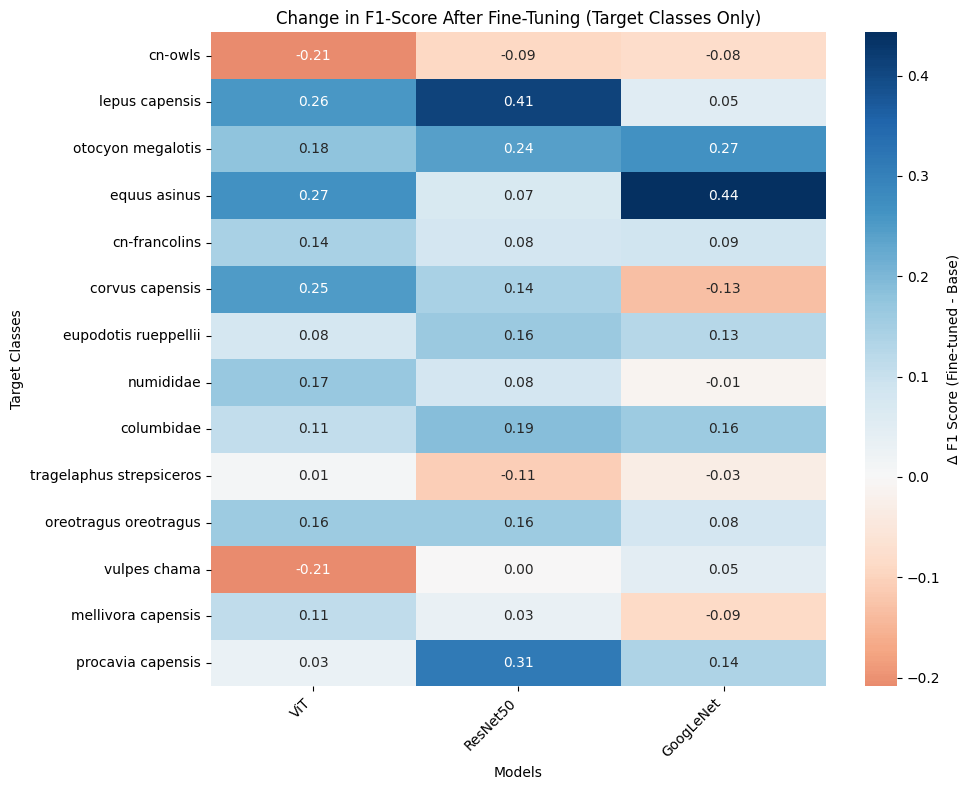

In [ ]:
# Focus on specific classes with extra data

target_classes = [
    'cn-owls', 'lepus capensis', 'otocyon megalotis', 'equus asinus',
    'cn-francolins', 'corvus capensis', 'eupodotis rueppellii', 'numididae',
    'columbidae', 'tragelaphus strepsiceros', 'oreotragus oreotragus',
    'vulpes chama', 'mellivora capensis', 'procavia capensis'
]

# Nur Target Klassen extrahieren
diff_f1_target_df = diff_f1_df.loc[target_classes]

# Speichern
diff_f1_target_df.to_csv(os.path.join(OUTPUT_FOLDER, "target_classes_f1_difference.csv"), index=True)
print("Target classes F1-Score differences saved.")

# Heatmap nur für Fokusklassen
plt.figure(figsize=(10, 8))
sns.heatmap(diff_f1_target_df, annot=True, cmap="RdBu", center=0, fmt=".2f",
            cbar_kws={'label': 'Δ F1 Score (Fine-tuned - Base)'})
plt.title('Change in F1-Score After Fine-Tuning (Target Classes Only)')
plt.xlabel('Models')
plt.ylabel('Target Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_FOLDER, "target_classes_f1_difference_heatmap.pdf"), dpi=300)
print("Heatmap for Target Classes saved.")

plt.show()

In [ ]:
# Top 5 und Bottom 5 Klassen basierend auf Durchschnitt
# (nachdem fine_f1_df schon nach F1 sortiert wurde)

top5_classes = fine_f1_df.head(5).index.tolist()
bottom5_classes = fine_f1_df.tail(5).index.tolist()

print("\n Top 5 classes (Fine-tuned Models):")
for cls in top5_classes:
    print(f"- {cls}")

print("\n Bottom 5 classes (Fine-tuned Models):")
for cls in bottom5_classes:
    print(f"- {cls}")


🏆 Top 5 classes (Fine-tuned Models):
- numididae
- corvus albus
- pteroclidae
- papio anubis
- eupodotis rueppellii

⚡ Bottom 5 classes (Fine-tuned Models):
- cn-owls
- canis mesomelas
- vulpes chama
- pronolagus randensis
- otocyon megalotis


In [ ]:
# Top 5 Improvements und Verschlechterungen pro Modell

for model_col in diff_f1_df.columns:
    print(f"\n Top 5 F1 Improvements for {model_col}:")
    top5_improvements = diff_f1_df[model_col].sort_values(ascending=False).head(5)
    for cls, improvement in top5_improvements.items():
        print(f"- {cls}: Δ {improvement:.4f}")

    print(f"\n Top 5 F1 Drops for {model_col}:")
    top5_drops = diff_f1_df[model_col].sort_values(ascending=True).head(5)
    for cls, drop in top5_drops.items():
        print(f"- {cls}: Δ {drop:.4f}")



📈 Top 5 F1 Improvements for Fine-tuned ViT:
- equus asinus: Δ 0.2667
- lepus capensis: Δ 0.2567
- corvus capensis: Δ 0.2500
- otocyon megalotis: Δ 0.1786
- numididae: Δ 0.1667

📉 Top 5 F1 Drops for Fine-tuned ViT:
- cn-owls: Δ -0.2088
- vulpes chama: Δ -0.2083
- pronolagus randensis: Δ -0.0818
- panthera leo: Δ -0.0403
- panthera pardus: Δ -0.0332

📈 Top 5 F1 Improvements for Fine-tuned ResNet50:
- lepus capensis: Δ 0.4099
- procavia capensis: Δ 0.3117
- otocyon megalotis: Δ 0.2424
- columbidae: Δ 0.1905
- raphiceros campestris: Δ 0.1885

📉 Top 5 F1 Drops for Fine-tuned ResNet50:
- pronolagus randensis: Δ -0.1641
- tragelaphus strepsiceros: Δ -0.1071
- cn-owls: Δ -0.0909
- panthera pardus: Δ -0.0459
- neotis ludwigii: Δ -0.0448

📈 Top 5 F1 Improvements for Fine-tuned GoogLeNet:
- equus asinus: Δ 0.4432
- otocyon megalotis: Δ 0.2667
- columbidae: Δ 0.1600
- procavia capensis: Δ 0.1375
- eupodotis rueppellii: Δ 0.1250

📉 Top 5 F1 Drops for Fine-tuned GoogLeNet:
- pronolagus randensis: Δ